# Decision Trees

In [1]:
# train a decision tree classifer on the iris dataset
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=4)
tree_clf.fit(X_iris, y_iris)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,4
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


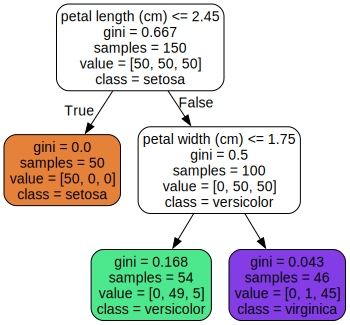

In [2]:
# visualize trained decision tree by using export_graphviz()
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    feature_names=["petal length (cm)", "petal width (cm)"],
    out_file="iris_tree.dot",
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

from graphviz import Source

Source.from_file("iris_tree.dot")

In [3]:
# see probability and prediction of dummy instance
print(tree_clf.predict_proba([[5, 1.5]]).round(3))
print(tree_clf.predict([[5, 1.5]]))

[[0.    0.907 0.093]]
[1]


In [4]:
# train one decision tree without regularization and one with min samples leaf = 5
# on the moons datasets
from sklearn.datasets import make_moons

X_moons, y_moons, = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [5]:
# see accuracies on a different moon dataset
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
print(tree_clf1.score(X_moons_test, y_moons_test))
print(tree_clf2.score(X_moons_test, y_moons_test))

0.898
0.92


The regularized model generalizes a bit better

## Regression

In [6]:
# train a regression tree on a noisy quadratic dataset with max_depth 2
import numpy as np
from sklearn.tree import DecisionTreeRegressor

X_quad = np.random.default_rng(seed=42).random((200,1)) - 0.5 # single ranodm input feature
y_quad = X_quad ** 2 + 0.025 * np.random.default_rng(seed=42).standard_normal((200,1))

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


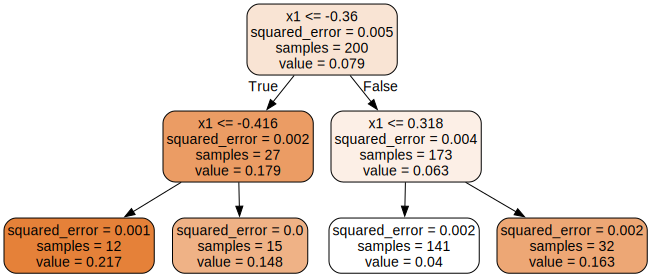

In [7]:
export_graphviz(
    tree_reg,
    out_file="quad_tree.dot",
    feature_names=["x1"],
    rounded=True,
    filled=True
)

Source.from_file("quad_tree.dot")

## Sensitivity to Axis Orientation

Scale and rotate (with PCA) data for easier Decision Tree training

In [8]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=2)
tree_clf_pca.fit(X_iris_rotated, y_iris)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,2
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


# Questions

## 7.
Train and fine-tune a decision tree for the moons dataset by following these steps:

a. Use make_moons(n_samples=10000, noise=0.4) to generate a moons dataset.

b. Use train_test_split() to split the dataset into a training set and a test set.

c. Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier.
**Hint**: try various values for max_leaf_nodes.

d. Train it on the full training set using these hyperparameters, and measure
your model’s performance on the test set. You should get roughly 85% to
87% accuracy.

In [9]:
X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.1, random_state=42)

In [10]:
from sklearn.model_selection import GridSearchCV

params = dict(max_leaf_nodes=range(24,65,8), max_depth=[3,4,5,6], min_samples_leaf=[1,5,10,15])
tree_clf = DecisionTreeClassifier(random_state=42)

search = GridSearchCV(tree_clf, params, cv=4, scoring="accuracy", n_jobs=-1)
search.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [3, 4, ...], 'max_leaf_nodes': range(24, 65, 8), 'min_samples_leaf': [1, 5, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [11]:
search.best_params_

{'max_depth': 6, 'max_leaf_nodes': 24, 'min_samples_leaf': 1}

In [12]:
search.best_estimator_.score(X_test, y_test) # 87% accuracy!!!

0.871

## 8.
Grow a forest by following these steps:

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. **Hint**: you can use Scikit-Learn’s ShuffleSplit class for this.

b. Train one decision tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 decision trees on the test set. Since they were trained on smaller sets, these decision trees will likely perform worse than the first decision tree, achieving only about 80% accuracy.

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 decision trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for this). This approach gives you majority-vote predictions over the test set.

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a random forest classifier!

In [13]:
# training all 1000 decision trees
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=1000, train_size=100, random_state=42)
test_scores = []
test_predictions = np.zeros(shape=(1000, y_test.shape[0]))
for i, (train_index, test_index) in enumerate(ss.split(X_train)):
    tree_clf = DecisionTreeClassifier(**search.best_params_, random_state=42)
    tree_clf.fit(X_train[train_index], y_train[train_index])
    test_scores.append(tree_clf.score(X_test, y_test))
    test_predictions[i,:] = tree_clf.predict(X_test)

In [14]:
print("Statistics of the decision trees:")
print("\tLowest test accuracy:", min(test_scores))
print("\tHighest test accuracy:", max(test_scores))
print("\tMean test accuracy:", np.mean(test_scores).round(3))
print("\tStandard deviation of test accuracy:", np.std(test_scores).round(3))

Statistics of the decision trees:
	Lowest test accuracy: 0.677
	Highest test accuracy: 0.862
	Mean test accuracy: 0.803
	Standard deviation of test accuracy: 0.029


In [15]:
# accuracy of the entire florest
from scipy.stats import mode

from sklearn.metrics import accuracy_score

accuracy_score(y_test, mode(test_predictions).mode)

0.868

Wait that is actually worse that the decision tree in question 7... that is disappointing... I am sure it is because all the trees were given the same prediction weight, so trees with worse score had the same influence as the trees with better score. It may also be the case that the subset size was too small. The score of the florest is better than the average score of the decision trees.